In [1]:
# import standard libraries
import numpy as np
from scipy.io import mmread, mmwrite
from scipy import linalg
from scipy import sparse
from scipy.integrate import ode
from numba import njit
import matplotlib.pyplot as plt
from pyscf import gto, dft
import numpy.ma as ma

# import methods for solving from other files
from adaptive_step_dmm import CAdaptiveDMM
from adaptive_C import CAdaptive_C_RK4
from adaptive_GC import CAdaptive_GC_RK4

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def gc_apply_method(H, S, num_electrons, beta, eps):
    # Invert S for calculation
    inv_S = linalg.inv(S)
    
    # Define chemical potential
    core_spec = linalg.eigvalsh(H, S)
    index = int(H.shape[0] / 2)
    mu = (core_spec[index] + core_spec[index - 1]) / 2
    
    # Define dbeta
    dbeta = beta / 10000
    
    # Run our GC method
    gc = CAdaptive_GC_RK4(ovlp=S, H=H, mu=mu, dbeta=dbeta, epsilon=eps)
    gc.propagate(beta)
    
    return gc

def c_apply_method(H, S, num_electrons, beta, eps):    
    # Define dbeta
    dbeta = beta / 10000
    
    # Run our C method
    c = CAdaptive_C_RK4(ovlp=S, H=H, num_electrons=num_electrons, dbeta=dbeta, epsilon=eps)
    c.propagate(beta)
    
    return c

In [4]:
'''
A simple example to run DFT calculation.
'''

# PBE Hydrogen flouride in a 6-31G basis set.
mol = gto.Mole()
mol.build(
    atom = 'H 0 0 0; F 0 0 1.1',  # in Angstrom
    basis = '631g',
    symmetry = True,
)

mf = dft.RKS(mol)
#mf.xc = 'blyp' # shorthand for b88,lyp
mf.xc = 'pbe' # shorthand for pbe,pbe
#mf.xc = 'lda,vwn_rpa'
#mf.xc = 'pbe0'
#mf.xc = 'b3lyp'

# this where self-content diagonalization happens
mf.kernel()

# Orbital energies, Mulliken population etc.
mf.analyze()

# Get the converged density matrix (it generates the density matrix)
dm = mf.make_rdm1()
mmwrite('dft_density.mtx', sparse.coo_matrix(dm))


# Get the nuclear-nuclear repulsion energy
e_nuc = mf.energy_nuc()
# Get the 'core' hamiltonian, corresponding to kinetic energy and e-nuclear repulsion terms
h1e = mf.get_hcore()
#mmwrite('dft_hcore.mtx', sparse.coo_matrix(h1e))
e1 = np.einsum('ij,ji', h1e, dm) # Compute the kinetic + e-nuclear repulsion energy
# Get the kohn-sham potential, including the Hartree coulomb repulsion and exchange-correlation potential, integrated on a grid
vhf = mf.get_veff(mf.mol, dm)
#print(type(vhf))
#print(vhf)
# Total energy
tot_e = e1 + vhf.ecoul + vhf.exc + e_nuc    # Total energy is sum of terms
print('Total dft energy: {}'.format(tot_e))

# chemical potential
index = int(mol.nelectron/2)
print(mol.nelectron)
dft_mu = (mf.mo_energy[index] + mf.mo_energy[index - 1]) / 2.
print('Chemical Potential: ', str(dft_mu))

# get the overlap matrix and print to file
ovlp = mf.get_ovlp()
inv_ovlp = linalg.inv(ovlp)

# Full fock matrix is sum of h1e and vhf
fock = h1e + vhf

# Get whole fock matrix directly corresponding to this density, without computing individual components
fock_direct = mf.get_fock(dm=dm)

# Check that ways to get the fock matrix are the same
assert(np.allclose(fock_direct,fock))

print("DFT trace: ", dm.trace())
core_spect = linalg.eigvalsh(h1e, ovlp)
print("Core eigvals: ", core_spect)
num_electrons = 10
index = int(h1e.shape[0]/2)
dmm_mu = (core_spect[index] + core_spect[index-1])/2
print(dmm_mu)

converged SCF energy = -100.291327706251
TODO: total wave-function symmetry for Coov
occupancy for each irrep:     A1  E1x  E1y
                               3    1    1
**** MO energy ****
MO #1 (A1 #1), energy= -24.2331671128069 occ= 2
MO #2 (A1 #2), energy= -1.02729722994609 occ= 2
MO #3 (A1 #3), energy= -0.426131190105547 occ= 2
MO #4 (E1x #1), energy= -0.289938520612839 occ= 2
MO #5 (E1y #1), energy= -0.28993852061284 occ= 2
MO #6 (A1 #4), energy= -0.034955913589636 occ= 0
MO #7 (A1 #5), energy= 0.664675049298749 occ= 0
MO #8 (E1x #2), energy= 1.1305709354121 occ= 0
MO #9 (E1y #2), energy= 1.1305709354121 occ= 0
MO #10 (A1 #6), energy= 1.24759809513674 occ= 0
MO #11 (A1 #7), energy= 1.57280313485608 occ= 0
 ** Mulliken atomic charges  **
charge of  0H =      0.35670
charge of  1F =     -0.35670
Dipole moment(X, Y, Z, Debye):  0.00000,  0.00000, -2.17040
Total dft energy: -100.29132770625061
10
Chemical Potential:  -0.16244721710123822
DFT trace:  7.1240097152571265
Core eigvals: 

In [5]:
beta = 1

gc = gc_apply_method(h1e, ovlp, num_electrons, beta, 1e-2)
gc_exact = ovlp @ linalg.funm(inv_ovlp @ h1e, lambda _ : np.exp(-beta*(_ - dmm_mu))/(1+np.exp(-beta*(_ - dmm_mu))))

funm result may be inaccurate, approximate err = 1


In [6]:
c = c_apply_method(h1e, ovlp, num_electrons, beta, 1e-2)
identity = np.eye(h1e.shape[0])
c_exact = ovlp @ linalg.funm(inv_ovlp @ h1e, lambda _ : np.exp(-beta*(_ - c.mu))/(1+np.exp(-beta*(_ - c.mu))))
c_exact *= 2 * num_electrons / ovlp.trace()

funm result may be inaccurate, approximate err = 1


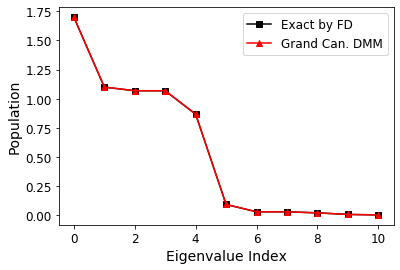

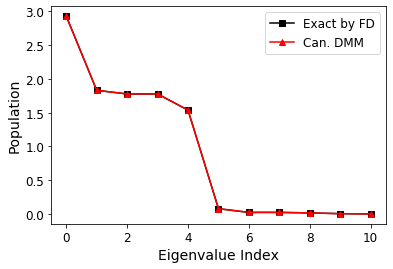

In [8]:
plt.figure(1)
plt.plot(linalg.eigvalsh(gc_exact)[::-1], 'ks-', label="Exact by FD")
plt.plot(linalg.eigvalsh(gc.rho)[::-1], 'r^-', label="Grand Can. DMM")
plt.ylabel("Population")
plt.xlabel("Eigenvalue Index")
plt.legend(numpoints=1)
plt.savefig("adaptive_gc_core_eigs.png", format='png', dpi=300)

plt.figure(2)
plt.plot(linalg.eigvalsh(c_exact)[::-1], 'ks-', label="Exact by FD")
plt.plot(linalg.eigvalsh(c.rho)[::-1], 'r^-', label="Can. DMM")
plt.ylabel("Population")
plt.xlabel("Eigenvalue Index")
plt.legend(numpoints=1)
plt.savefig("adaptive_c_core_eigs.png", format='png', dpi=300)